In [1]:
from prototype2_SizeSlabModel import ASTroCATclone #, new_plot

In [2]:
import pickle
filehandler = open('forcing_47_minus20.obj', 'rb') 
forx = pickle.load(filehandler)

In [3]:
import numpy as np
import xarray as xr
import xsimlab as xs
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [4]:
# RUN 67

model_in = xs.create_setup(
        model=ASTroCATclone,
    clocks={
         'time': np.linspace(1,365*15,365*15*60)  # 10*365,10*365*9)
     },
    input_vars={
        'N__initVal':1,    # inital Nutrient amount
        'N__supplyrate':5, # nutrient supply rate
        
        'P__initVal': 1,   # inital total biomass of Phytoplankton
        'P__PMinEsd': .5,   # minimal Phytoplankton Size Spectral range
        'P__PMaxEsd': 50,  # minimal Phytoplankton Size Spectral range
        'P__NP': 20,       # number of Phytoplankton Types (=num of Zooplankton Types)
        'P__m': .01,        # mortality rate of Phytoplankton
        'P__kw': 0.4,
        'P__kc': 0.3,
        'P__OptI':20,
        
        'Z__initVal': 1,   # inital total biomass of Zooplankton
        'Z__zeta': .1,      # mortality rate quadratic
        'Z__deltaxprey': .25,  # log10 prey size tolerance
        'Z__KsZ': 7,       # grazing half saturation constant  # 3 '"'"'"'"'"'"':!:!:!:!:!::!:!:!::!:!:!::!!'"'"'"'"'"'"'
        'Z__f_eg': .33,    # egested food
        'Z__epsilon': .33,  # assimilated food
        
        'D__initVal': 0.1,  # initial Detritus Biomass
        'D__remin_rate': 0.15,  # Detritus remineralization rate
        
        'env__kappa':0.1  # diffusive mixing constant
    },
    output_vars={
        'env__component': None,
        'P__size': None,
        'Z__size': None,
        'env__stateout': 'time'
    }
)



#model_out = model_in.xsimlab.run(model=ASTroCATclone)


#model_out.to_netcdf('SSS_plotoutput_01.nc')

In [5]:
model_out = xr.load_dataset('SSS_plotoutput_01.nc')

FileNotFoundError: [Errno 2] No such file or directory: b'/home/bpost/kaweahcode/phydra_OSM/SizeSpectralSlab/SSS_plotoutput_01.nc'

In [58]:
def new_plot(modeloutput, forcingverif, Pnum):
   
    data_coordfix = modeloutput.set_index(component = 'env__component', P__sizes='P__size', Z__sizes='Z__size')

    P_out = data_coordfix.sel(component=['P'+str(i) for i in range(Pnum)])
    Z_out = data_coordfix.sel(component=['Z'+str(i) for i in range(Pnum)])
    N_out = data_coordfix.sel(component='N')
    D_out = data_coordfix.sel(component='D')

    resolution = 10
    resmpl_step = 1


    P_pico = P_out.env__stateout[:,P_out.P__sizes.values<2]
    mask = ((P_out.P__sizes.values >= 2) & (P_out.P__sizes.values <= 20))
    P_nano = P_out.env__stateout[:,mask]
    mask2 = ((P_out.P__sizes.values >= 20) & (P_out.P__sizes.values <= 50))
    P_micro = P_out.env__stateout[:,mask2]
    ##########
    
    
    P_pico_sum = P_pico.sum(dim='component')
    P_nano_sum = P_nano.sum(dim='component')
    P_micro_sum = P_micro.sum(dim='component')
    
    Z_out_sum = Z_out.sum(dim='component')
    
    ##########
    P_pico_sum_ly = P_pico_sum[P_pico_sum.time > 365*10]
    P_nano_sum_ly = P_nano_sum[P_nano_sum.time > 365*10]
    P_micro_sum_ly = P_micro_sum[P_micro_sum.time > 365*10]

    N_out_ly = N_out.env__stateout[N_out.time > 365*10]
    D_out_ly = D_out.env__stateout[D_out.time > 365*10]
    Z_out_ly = Z_out_sum.env__stateout[Z_out.time > 365*10]

    P_pico_sum_ly_yday = P_pico_sum_ly.assign_coords(time=np.mod(P_pico_sum_ly.time, 365.))
    P_nano_sum_ly_yday = P_nano_sum_ly.assign_coords(time=np.mod(P_nano_sum_ly.time, 365.))
    P_micro_sum_ly_yday = P_micro_sum_ly.assign_coords(time=np.mod(P_micro_sum_ly.time, 365.))

    N_out_ly_yday = N_out_ly.assign_coords(time=np.mod(N_out_ly.time, 365.))
    D_out_ly_yday = D_out_ly.assign_coords(time=np.mod(D_out_ly.time, 365.))
    Z_out_ly_yday = Z_out_ly.assign_coords(time=np.mod(Z_out_ly.time, 365.))
    #################

    import datetime

    seconds = P_pico_sum_ly_yday.time.values * 60 * 60 * 24

    dt_array = [datetime.datetime.utcfromtimestamp(i) for i in seconds]
    #################

    P_pico_sum_ly_dt = P_pico_sum_ly_yday.assign_coords(time=dt_array).to_dataset()
    P_nano_sum_ly_dt = P_nano_sum_ly_yday.assign_coords(time=dt_array).to_dataset()
    P_micro_sum_ly_dt = P_micro_sum_ly_yday.assign_coords(time=dt_array).to_dataset()

    N_out_ly_dt = N_out_ly_yday.assign_coords(time=dt_array).to_dataset()
    D_out_ly_dt = D_out_ly_yday.assign_coords(time=dt_array).to_dataset()
    Z_out_ly_dt = Z_out_ly_yday.assign_coords(time=dt_array).to_dataset()
    
    timeagg = 'time.dayofyear'
    P_pico_yagg = P_pico_sum_ly_dt.groupby(timeagg).mean()
    P_pico_yagg_sd = P_pico_sum_ly_dt.groupby(timeagg).std()

    P_nano_yagg = P_nano_sum_ly_dt.groupby(timeagg).mean()
    P_nano_yagg_sd = P_nano_sum_ly_dt.groupby(timeagg).std()

    P_micro_yagg = P_micro_sum_ly_dt.groupby(timeagg).mean()
    P_micro_yagg_sd = P_micro_sum_ly_dt.groupby(timeagg).std()

    N_out_yagg = N_out_ly_dt.groupby(timeagg).mean()
    N_out_yagg_sd = N_out_ly_dt.groupby(timeagg).std()

    D_out_yagg = D_out_ly_dt.groupby(timeagg).mean()
    D_out_yagg_sd = D_out_ly_dt.groupby(timeagg).std()
    
    Z_out_yagg = Z_out_ly_dt.groupby(timeagg).mean()
    Z_out_yagg_sd = Z_out_ly_dt.groupby(timeagg).std()

    # conversion
    CtoN = 106/16
    molarmassC = 12.0107
    CBMconvert = molarmassC * CtoN
    
    ##########
    dayspermonth = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    dpm_cumsum = np.cumsum(dayspermonth) - np.array(dayspermonth)/2 #- 15
    
    #new
    dpy = np.arange(1,366)

    ##########
    
    
    plt.rcParams['figure.figsize'] = [8, 5]

    #c to N # 106/16
    labels = {'model_pico':'darkgreen','model_nano':'green','model_micro':'lightgreen', 'model_nuts':'blue','model_det':'brown','model_Z':'red','data':'grey'}
    markers = {'pico':'x', 'nano':'^', 'micro':'s', 'nuts':'s', 'det':'s'}

    #fig, ax = plt.subplots(1, 3, sharey='row')
    fig = plt.figure(constrained_layout=True)


    gs = fig.add_gridspec(nrows=2, ncols=3, hspace=0.1, wspace=0.1)#, height_ratios=[.1,1,1,.1,1])

    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[0, 1])#, sharey=ax0)
    ax2 = fig.add_subplot(gs[0, 2])#, sharey=ax0)
    ax3 = fig.add_subplot(gs[1, 0])
    ax4 = fig.add_subplot(gs[1, 1])
    ax5 = fig.add_subplot(gs[1, 2])

    def plotdataanderr(axe,data,error,forcing, color, fxlab):
        if forcing is not None:
            axe.scatter(dpm_cumsum, forcing, label=fxlab, c=labels['data'])
        axe.plot(dpy, data, label='model', c=color)
        axe.fill_between(dpy, data-error, data+error, color=color, alpha=0.2)
        
            
    plotdataanderr(ax0, P_pico_yagg.env__stateout, P_pico_yagg_sd.env__stateout, np.array(forcingverif.verif.c_picop) /CBMconvert, labels['model_pico'], 'satellite')
    
    
    plotdataanderr(ax1, P_nano_yagg.env__stateout, P_nano_yagg_sd.env__stateout, np.array(forcingverif.verif.c_nanop) /CBMconvert, labels['model_nano'], 'satellite')
    
    
    plotdataanderr(ax2, P_micro_yagg.env__stateout, P_micro_yagg_sd.env__stateout, np.array(forcingverif.verif.c_microp) /CBMconvert, labels['model_micro'], 'satellite')
    
    
    plotdataanderr(ax3, N_out_yagg.env__stateout, N_out_yagg_sd.env__stateout, np.array(forcingverif.verif.N), labels['model_nuts'], 'WOA data')
    
    
    plotdataanderr(ax4, Z_out_yagg.env__stateout, Z_out_yagg_sd.env__stateout, None, labels['model_Z'], '')
    
    
    plotdataanderr(ax5, D_out_yagg.env__stateout, D_out_yagg_sd.env__stateout, None, labels['model_det'], '')
    
    """
    # Phyto MODEL
    ax0.errorbar(dpm_cumsum, P_pico_yagg.env__stateout, P_pico_yagg_sd.env__stateout, linestyle='None', c=labels['model_pico'])#, marker='^')
    ax0.scatter(dpm_cumsum, P_pico_yagg.env__stateout, label='model', c=labels['model_pico'], marker=markers['pico'])

    ax1.errorbar(dpm_cumsum, P_nano_yagg.env__stateout, P_nano_yagg_sd.env__stateout, linestyle='None', c=labels['model_nano'])#, marker='^')
    ax1.scatter(dpm_cumsum, P_nano_yagg.env__stateout, label='model', c=labels['model_nano'], marker=markers['nano'])

    ax2.errorbar(dpm_cumsum, P_micro_yagg.env__stateout, P_micro_yagg_sd.env__stateout, linestyle='None', c=labels['model_micro'])
    ax2.scatter(dpm_cumsum, P_micro_yagg.env__stateout, label='model', c=labels['model_micro'], marker=markers['micro'])

    # Phyto DATA

    ax0.errorbar(dpm_cumsum, np.array(forcingverif.verif.c_picop) /CBMconvert, np.array(forcingverif.verif.c_picop_sd) /CBMconvert, linestyle='None', capsize = 4,capthick = 1.5, linewidth=0.1, c=labels['data'])
    ax0.scatter(dpm_cumsum, np.array(forcingverif.verif.c_picop) /CBMconvert , label='satellite', c=labels['data'])

    ax1.errorbar(dpm_cumsum, np.array(forcingverif.verif.c_nanop) /CBMconvert, np.array(forcingverif.verif.c_nanop_sd) /CBMconvert, linestyle='None', capsize = 4,capthick = 1.5, linewidth=0.1, c=labels['data'])
    ax1.scatter(dpm_cumsum, np.array(forcingverif.verif.c_nanop) /CBMconvert , label='satellite', c=labels['data'])

    ax2.errorbar(dpm_cumsum, np.array(forcingverif.verif.c_microp) /CBMconvert, np.array(forcingverif.verif.c_microp_sd) /CBMconvert, linestyle='None', capsize = 4,capthick = 1.5, linewidth=0.1, c=labels['data'])
    ax2.scatter(dpm_cumsum, np.array(forcingverif.verif.c_microp) /CBMconvert , label='satellite', c=labels['data'])


    # NUTRIENTS
    #ax3.errorbar(dpm_cumsum, N_out_yagg.env__stateout, N_out_yagg_sd.env__stateout, linestyle='None', c=labels['model_nuts'])#, marker='^')
    #ax3.scatter(dpm_cumsum, N_out_yagg.env__stateout, label='model', c=labels['model_nuts'], marker=markers['nuts'])

    ax3.scatter(dpm_cumsum, np.array(forcingverif.verif.N) , label='WOA data', c=labels['data'])

    # DETITUS
    ax4.errorbar(dpm_cumsum, D_out_yagg.env__stateout, D_out_yagg_sd.env__stateout, linestyle='None', c=labels['model_det'])#, marker='^')
    ax4.scatter(dpm_cumsum, D_out_yagg.env__stateout, label='model', c=labels['model_det'], marker=markers['det'])

    # Zooplankton
    ax5.errorbar(dpm_cumsum, Z_out_yagg.env__stateout, Z_out_yagg_sd.env__stateout, linestyle='None', c=labels['model_Z'])#, marker='^')
    ax5.scatter(dpm_cumsum, Z_out_yagg.env__stateout, label='model', c=labels['model_Z'], marker=markers['det'])
    """

    # LABELS
    ax0.set_title('Pico (0.5 - 2 µm)')
    ax1.set_title('Nano (2 - 20 µm)')
    ax2.set_title('Micro (20 - 50 µm)')

    ax0.set_ylabel('Phytoplankton  [µM N]')
    ax1.set_xlabel('Day in year [days]')


    ax3.set_title('N')

    ax3.set_ylabel('Nitrogen [µM N]')
    ax3.set_xlabel('Day in year [days]')


    ax4.set_title('D')

    ax4.set_ylabel('Detritus [µM N]')
    ax4.set_xlabel('Day in year [days]')
    
    ax5.set_title('sum(Z)')

    ax5.set_ylabel('Zooplankton [µM N]')
    ax5.set_xlabel('Day in year [days]')

    #plt.plot(P_pico_yagg.month, P_pico_yagg.env__stateout, label=labels['pico'])
    #plt.plot(P_nano_yagg.month, P_nano_yagg.env__stateout, label=labels['nano'])
    #plt.plot(P_micro_yagg.month, P_micro_yagg.env__stateout, label=labels['micro'])

    #plt.scatter(P_nano_sum_ly_yday.time.values, P_nano_sum_ly_yday.values, label='nano')
    #plt.scatter(P_micro_sum_ly_yday.time.values, P_micro_sum_ly_yday.values, label='micro')
    xlim = (1, 365)
    from matplotlib.ticker import MaxNLocator
    for axe in [ax0, ax1, ax2, ax3, ax4, ax5]:
        axe.legend(fontsize='x-small')
        plt.setp(axe, xticks=[1,60,120,180,240,300,365], xlim=xlim)
        axe.grid(True, alpha=0.5)
        axe.get_yaxis().set_major_locator(MaxNLocator(nbins=5))
        axe.tick_params(top=False, right=True, direction="in")
        axe.set_ylim(bottom=0)
    
    for axe in [ax0,ax2]:
        axe.set_ylim(0,.5)
    
    for axe in [ax1]:
        axe.set_ylim(0,3)

        
    #plt.setp(ax1.get_yticklabels(), visible=False)
    #plt.setp(ax2.get_yticklabels(), visible=False)

    # Defining custom 'xlim' and 'ylim' values.

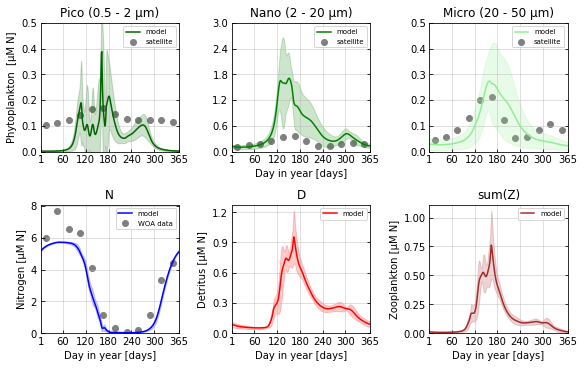

In [59]:
new_plot(model_out,forx, 20)

In [11]:
2 - 0.5

1.5

In [12]:
20 - 2

18

In [13]:
50 - 20

30

In [14]:
20/50

0.4

In [16]:
2 / 20

0.1

In [18]:
0.5 / 2

0.25